In [1]:
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import re
import nltk
#nltk.download('stopwords')

### Objective - To Perform Sentiment analysis using RNN, LSTM, Bidirectional LSTM, GRU and Bidirectional GRU

### DATASET
The dataset used is the Hotel Review Dataset. It is a CSV file containing 5,15,000 customer reviews and scoring of 1493 luxury hotels across Europe. It has 17 fields/variables 
The website containing the dataset - https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe

In [2]:
#importing dataset
data = pd.read_csv("Hotel_Reviews.csv")

In [3]:
data.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


In [4]:
data.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng'],
      dtype='object')

### Data Preprocessing

In [5]:
print(f"Negative reviews : {data['Negative_Review'].head()} \n Postive reviews : {data['Positive_Review'].head()}")

Negative reviews : 0     I am so angry that i made this post available...
1                                          No Negative
2     Rooms are nice but for elderly a bit difficul...
3     My room was dirty and I was afraid to walk ba...
4     You When I booked with your company on line y...
Name: Negative_Review, dtype: object 
 Postive reviews : 0     Only the park outside of the hotel was beauti...
1     No real complaints the hotel was great great ...
2     Location was good and staff were ok It is cut...
3     Great location in nice surroundings the bar a...
4      Amazing location and building Romantic setting 
Name: Positive_Review, dtype: object


Each text is split into postive and negative review. Thus, we will combine them.

In [6]:
data['Reviewer_Score'].head()

0    2.9
1    7.5
2    7.1
3    3.8
4    6.7
Name: Reviewer_Score, dtype: float64

Only the review text and score are considered for this sentiment analysis. Hence, the new dataframe wil only consist of 2 columns - Positive and Negative reviews combined and Review Score

In [7]:
data["Review"] =data['Positive_Review']+ data['Negative_Review'] 
data = data[["Review",'Reviewer_Score']]
data

,Review,Reviewer_Score
0,Only the park outside of the hotel was beauti...,2.9
1,No real complaints the hotel was great great ...,7.5
2,Location was good and staff were ok It is cut...,7.1
3,Great location in nice surroundings the bar a...,3.8
4,Amazing location and building Romantic settin...,6.7
...,...,...
515733,location no trolly or staff to help you take ...,7.0
515734,Breakfast was ok and we got earlier check in ...,5.8
515735,No Positive The ac was useless It was a hot we...,2.5
515736,The rooms are enormous and really comfortable...,8.8


#### Converting the review scores to only 0 and 1 : <br>
0 if review is negative and 1 if positive.  <br>
Values less than 5.5 is taken as negative (0) and 5.5 and above as positive (1)
#### Removing the words "No negative" and "No positive"  <br>
If there are no positive or negative words, they have the terms "No negative" and "No positive". <br>
As it is of no use to the analysis, they are removed.

In [8]:
data["Reviewer_Score"] = data["Reviewer_Score"].apply(lambda x: 0 if x < 5.5 else 1)
data["Review"] = data["Review"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))
data.head()

,Review,Reviewer_Score
0,Only the park outside of the hotel was beauti...,0
1,No real complaints the hotel was great great ...,1
2,Location was good and staff were ok It is cut...,1
3,Great location in nice surroundings the bar a...,0
4,Amazing location and building Romantic settin...,1


Removing Stopwords and Making all words in lowercase

In [9]:
stop = stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text.split() if word not in stop]
    return ' '.join(text)
data['Review'] = data['Review'].apply(remove_stopwords)
data['Review'] = data['Review'].apply(lambda x: x.lower())
data.head()

,Review,Reviewer_Score
0,only park outside hotel beautiful i angry made...,0
1,no real complaints hotel great great location ...,1
2,location good staff ok it cute hotel breakfast...,1
3,great location nice surroundings bar restauran...,0
4,amazing location building romantic setting you...,1


Converting text to sequences

In [10]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['Review'])
sequences = tokenizer.texts_to_sequences(data['Review'])
sequences[:5][:5]

[[328,
  168,
  135,
  5,
  105,
  6,
  3378,
  79,
  2548,
  162,
  791,
  641,
  962,
  130,
  1789,
  28,
  171,
  1275,
  111,
  85,
  6,
  79,
  111,
  791,
  111,
  344,
  20,
  97,
  522,
  269,
  5,
  882,
  1528,
  2899,
  563,
  202,
  1007,
  18,
  1,
  1055,
  65,
  5,
  34,
  729,
  1,
  126,
  6,
  1298,
  1593,
  67,
  521,
  3893,
  1,
  21,
  81,
  240,
  167,
  2283,
  2,
  1,
  208,
  972,
  418,
  144,
  424,
  3151,
  1398,
  330,
  352,
  3695,
  1045,
  604,
  346,
  6,
  128,
  349,
  1,
  3044,
  67,
  210,
  126,
  3893,
  4629,
  1312,
  819,
  143,
  99,
  147,
  2970,
  287,
  167,
  903,
  312,
  1,
  68,
  53,
  386,
  52,
  68,
  53,
  882,
  1731,
  413,
  44,
  1,
  101,
  113,
  147,
  3750,
  944,
  386,
  302,
  757,
  1663,
  562,
  413,
  52,
  200,
  1,
  165,
  48,
  2,
  1,
  99,
  301,
  1143,
  1737,
  539,
  49,
  81,
  144,
  20,
  355,
  480,
  1,
  1007,
  3120,
  2549,
  66,
  293,
  261,
  729,
  1539,
  110,
  1,
  1024,
  79,
  3094,


Pad Sequences

In [11]:
padding = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')
padding[:5][:5]

array([[ 328,  168,  135,    5,  105,    6, 3378,   79, 2548,  162,  791,
         641,  962,  130, 1789,   28,  171, 1275,  111,   85,    6,   79,
         111,  791,  111,  344,   20,   97,  522,  269,    5,  882, 1528,
        2899,  563,  202, 1007,   18,    1, 1055,   65,    5,   34,  729,
           1,  126,    6, 1298, 1593,   67,  521, 3893,    1,   21,   81,
         240,  167, 2283,    2,    1,  208,  972,  418,  144,  424, 3151,
        1398,  330,  352, 3695, 1045,  604,  346,    6,  128,  349,    1,
        3044,   67,  210,  126, 3893, 4629, 1312,  819,  143,   99,  147,
        2970,  287,  167,  903,  312,    1,   68,   53,  386,   52,   68,
          53],
       [  46,  530,  735,    5,    9,    9,    4, 1559,   15,  473,   24,
          96, 1424,  204, 3498,    3,  563,   52, 1583, 1569,  793, 3901,
           3,  432,  563,  698, 1105, 1353,  904,  171,  200,   28,   42,
        1583, 4412,  558,   56,   42, 1742,   41,  369,   17,  140,   47,
         676, 2014, 301

#### Spliting data into Train and Test test

In [12]:
X = padding
y = data["Reviewer_Score"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Building Model
### a) RNN

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta = 0.01,  restore_best_weights = True)

Early stopping is applied for all models. If the loss between consecutive epochs is 0.01 or less 3 times, the training <br>
will be stopped early and the best weights will be taken.

#### Model 1

In [14]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta = 0.01,  restore_best_weights = True)
model1 = Sequential()
model1.add(Embedding(5000, 16, input_length=100))
model1.add(SimpleRNN(32))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           80000     
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1568      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 81,601
Trainable params: 81,601
Non-trainable params: 0
_________________________________________________________________


In [15]:
history1 = model1.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test),
                      batch_size=512, verbose=1,callbacks=[callback])

Epoch 1/15
806/806 [==============================] - 70s 84ms/step - loss: 0.2782 - accuracy: 0.9212 - val_loss: 0.2785 - val_accuracy: 0.9160
Epoch 2/15
806/806 [==============================] - 57s 71ms/step - loss: 0.2714 - accuracy: 0.9220 - val_loss: 0.2761 - val_accuracy: 0.9206
Epoch 3/15
806/806 [==============================] - 37s 46ms/step - loss: 0.2688 - accuracy: 0.9222 - val_loss: 0.2720 - val_accuracy: 0.9205
Epoch 4/15
806/806 [==============================] - 35s 43ms/step - loss: 0.2656 - accuracy: 0.9232 - val_loss: 0.2715 - val_accuracy: 0.9206
Epoch 5/15
806/806 [==============================] - 32s 39ms/step - loss: 0.2649 - accuracy: 0.9237 - val_loss: 0.2714 - val_accuracy: 0.9209
Epoch 6/15
806/806 [==============================] - 36s 45ms/step - loss: 0.2656 - accuracy: 0.9239 - val_loss: 0.2759 - val_accuracy: 0.9205
Epoch 7/15
806/806 [==============================] - 38s 47ms/step - loss: 0.2677 - accuracy: 0.9240 - val_loss: 0.2763 - val_accuracy:

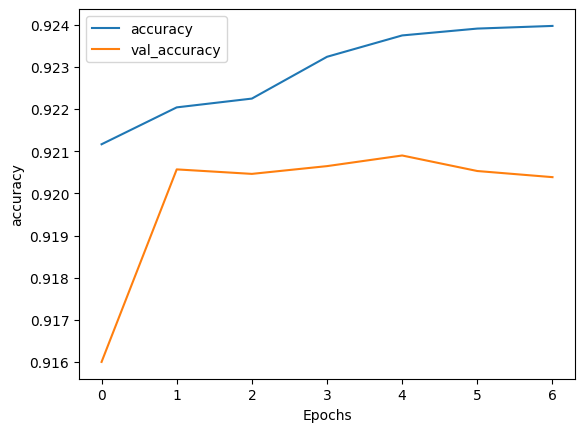

In [79]:
plot_graphs(history1, 'accuracy')

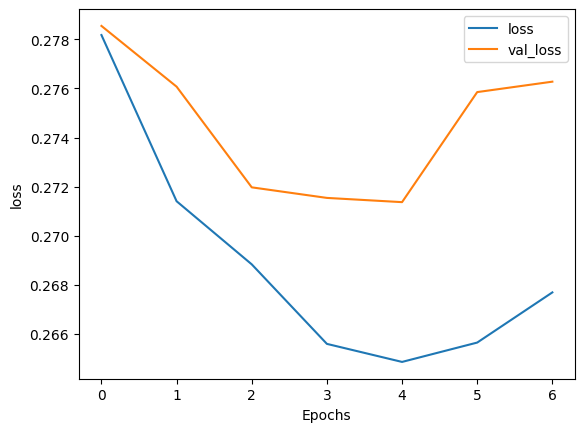

In [81]:
plot_graphs(history1, 'loss')

In [124]:
score1 = model1.evaluate(X_test, y_test, batch_size = 512)
print("\nTest score:", score1[0]) 
print('Test accuracy:', score1[1])

202/202 [==============================] - 11s 54ms/step - loss: 0.2715 - accuracy: 0.9206

Test score: 0.27153846621513367
Test accuracy: 0.9206479787826538


#### Model 2

Input Layer = 15000, Output Layer = 30, Layers = 32, Activation = Relu, <br>
Optimizer = RMSprop, Dropout = 0.5, Batch size = 1024,epoch = 35 	

In [17]:
model2 = Sequential()
model2.add(Embedding(15000, 30, input_length=100))
model2.add(SimpleRNN(32))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='relu'))
model2.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 30)           450000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                2016      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 452,049
Trainable params: 452,049
Non-trainable params: 0
_________________________________________________________________


In [18]:
history2 = model2.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test),
                      batch_size=1024, verbose=0,callbacks=[callback])

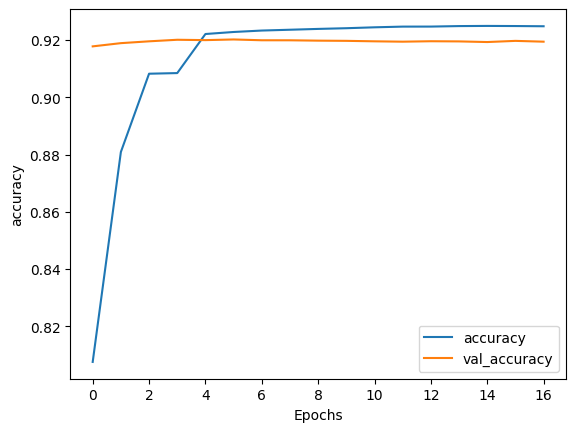

In [82]:
plot_graphs(history2, 'accuracy')

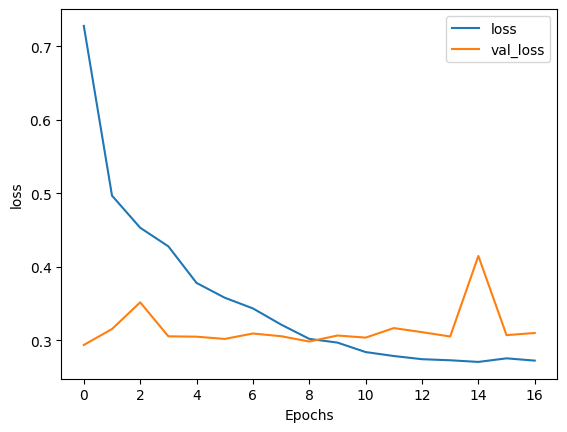

In [83]:
plot_graphs(history2, 'loss')

In [125]:
score2 = model2.evaluate(X_test, y_test, batch_size = 1024)
print("\nTest score:", score2[0]) 
print('Test accuracy:', score2[1])

101/101 [==============================] - 12s 115ms/step - loss: 0.3053 - accuracy: 0.9195

Test score: 0.3053150475025177
Test accuracy: 0.9195330739021301


Accuracy of Model 2 is less than 1. 

### b) LSTM

#### Model 3

In [19]:
# lstm model
model3 = Sequential()
model3.add(Embedding(5000, 16, input_length=100))
model3.add(LSTM(32))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 16)           80000     
                                                                 
 lstm (LSTM)                 (None, 32)                6272      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 86,305
Trainable params: 86,305
Non-trainable params: 0
_________________________________________________________________


In [20]:
history3 = model3.fit(X_train, y_train, epochs=10, batch_size = 512, 
                      validation_data=(X_test, y_test), verbose=1,callbacks=[callback])

Epoch 1/10
806/806 [==============================] - 113s 138ms/step - loss: 0.2683 - accuracy: 0.9224 - val_loss: 0.1921 - val_accuracy: 0.9307
Epoch 2/10
806/806 [==============================] - 112s 139ms/step - loss: 0.1718 - accuracy: 0.9352 - val_loss: 0.1694 - val_accuracy: 0.9348
Epoch 3/10
806/806 [==============================] - 110s 137ms/step - loss: 0.1630 - accuracy: 0.9376 - val_loss: 0.1704 - val_accuracy: 0.9346
Epoch 4/10
806/806 [==============================] - 109s 136ms/step - loss: 0.1591 - accuracy: 0.9388 - val_loss: 0.1666 - val_accuracy: 0.9361
Epoch 5/10
806/806 [==============================] - 115s 143ms/step - loss: 0.1557 - accuracy: 0.9402 - val_loss: 0.1734 - val_accuracy: 0.9351
Epoch 6/10
806/806 [==============================] - 115s 142ms/step - loss: 0.1537 - accuracy: 0.9409 - val_loss: 0.1703 - val_accuracy: 0.9363
Epoch 7/10
806/806 [==============================] - 112s 139ms/step - loss: 0.1524 - accuracy: 0.9412 - val_loss: 0.1773 -

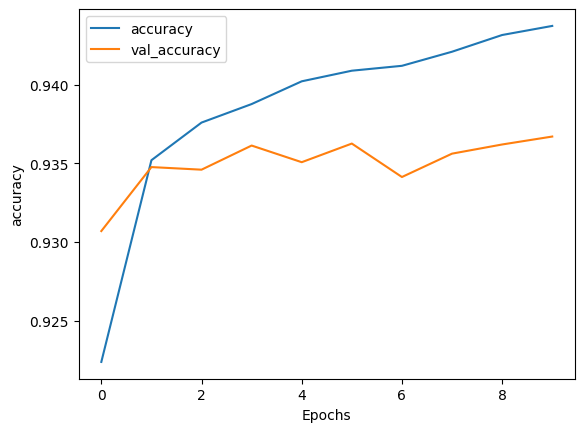

In [84]:
plot_graphs(history3, 'accuracy')

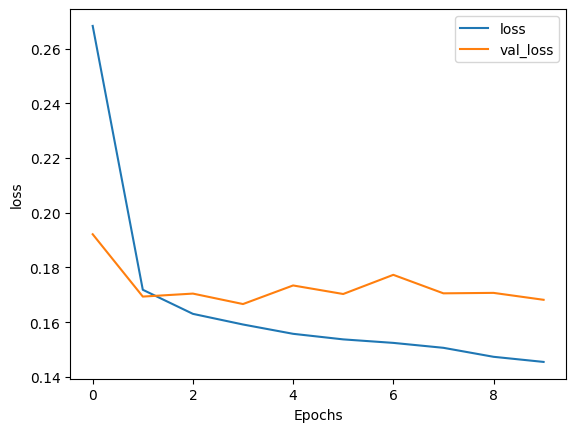

In [85]:
plot_graphs(history3, 'loss')

In [126]:
score3 = model3.evaluate(X_test, y_test, batch_size = 512)
print("\nTest score:", score3[0]) 
print('Test accuracy:', score3[1])

202/202 [==============================] - 33s 161ms/step - loss: 0.1682 - accuracy: 0.9367

Test score: 0.16817724704742432
Test accuracy: 0.9367026090621948


#### Model 4

Input Layer = 35000, Output Layer = 40, Layers = 200, Dropout = 0.75,<br>
Activation = Sigmoid, Optimizer = SGD, Batch size = 1024,epoch = 25 	

In [25]:
# lstm model
model4 = Sequential()
model4.add(Embedding(35000, 40, input_length=100))
model4.add(LSTM(200))
model4.add(Dropout(0.75))
model4.add(Dense(1, activation='sigmoid'))
model4.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
model4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 40)           1400000   
                                                                 
 lstm_3 (LSTM)               (None, 200)               192800    
                                                                 
 dropout_3 (Dropout)         (None, 200)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 201       
                                                                 
Total params: 1,593,001
Trainable params: 1,593,001
Non-trainable params: 0
_________________________________________________________________


In [27]:
history4 = model4.fit(X_train, y_train, epochs=25, batch_size = 1024, 
                      validation_data=(X_test, y_test), verbose=2,callbacks=[callback])

Epoch 1/25
403/403 [==============================] - 1088s 3s/step - loss: 0.3254 - accuracy: 0.9223 - val_loss: 0.2766 - val_accuracy: 0.9207
Epoch 2/25
403/403 [==============================] - 1133s 3s/step - loss: 0.2781 - accuracy: 0.9223 - val_loss: 0.2766 - val_accuracy: 0.9207
Epoch 3/25
403/403 [==============================] - 1121s 3s/step - loss: 0.2777 - accuracy: 0.9223 - val_loss: 0.2766 - val_accuracy: 0.9207
Epoch 4/25
403/403 [==============================] - 1126s 3s/step - loss: 0.2773 - accuracy: 0.9223 - val_loss: 0.2766 - val_accuracy: 0.9207
Epoch 5/25
403/403 [==============================] - 1123s 3s/step - loss: 0.2770 - accuracy: 0.9223 - val_loss: 0.2766 - val_accuracy: 0.9207
Epoch 6/25
403/403 [==============================] - 1117s 3s/step - loss: 0.2765 - accuracy: 0.9223 - val_loss: 0.2766 - val_accuracy: 0.9207
Epoch 7/25
403/403 [==============================] - 1117s 3s/step - loss: 0.2766 - accuracy: 0.9223 - val_loss: 0.2766 - val_accuracy:

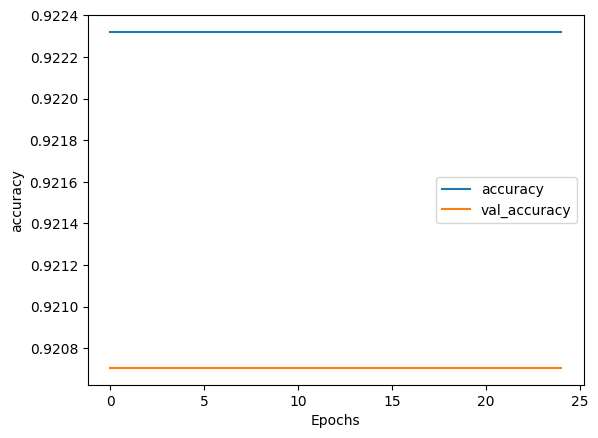

In [86]:
plot_graphs(history4, 'accuracy')

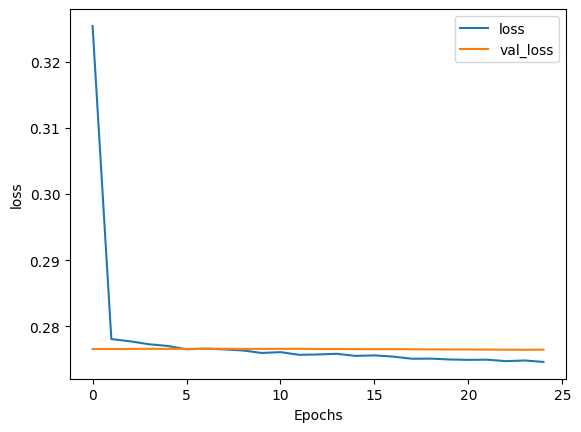

In [87]:
plot_graphs(history4, 'loss')

In [127]:
score4 = model4.evaluate(X_test, y_test, batch_size = 1024)
print("\nTest score:", score4[0]) 
print('Test accuracy:', score4[1])

101/101 [==============================] - 126s 1s/step - loss: 0.2765 - accuracy: 0.9207

Test score: 0.2764594256877899
Test accuracy: 0.9207061529159546


### c) BLSTM

#### Model 5

In [28]:
# Bidirectional LSTM model
model5 = Sequential()
model5.add(Embedding(5000, 16, input_length=100))
model5.add(Bidirectional(LSTM(32)))
model5.add(Dense(1, activation='sigmoid'))
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model5.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 16)           80000     
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 92,609
Trainable params: 92,609
Non-trainable params: 0
_________________________________________________________________


In [29]:
history5 = model5.fit(X_train, y_train, epochs=10, batch_size=512, validation_data=(X_test, y_test), 
                      verbose=2,callbacks=[callback])

Epoch 1/10
806/806 - 317s - loss: 0.1989 - accuracy: 0.9316 - val_loss: 0.1674 - val_accuracy: 0.9357 - 317s/epoch - 394ms/step
Epoch 2/10
806/806 - 318s - loss: 0.1581 - accuracy: 0.9385 - val_loss: 0.1627 - val_accuracy: 0.9375 - 318s/epoch - 394ms/step
Epoch 3/10
806/806 - 317s - loss: 0.1521 - accuracy: 0.9405 - val_loss: 0.1610 - val_accuracy: 0.9381 - 317s/epoch - 393ms/step
Epoch 4/10
806/806 - 317s - loss: 0.1474 - accuracy: 0.9425 - val_loss: 0.1613 - val_accuracy: 0.9384 - 317s/epoch - 394ms/step
Epoch 5/10
806/806 - 318s - loss: 0.1438 - accuracy: 0.9436 - val_loss: 0.1602 - val_accuracy: 0.9386 - 318s/epoch - 395ms/step
Epoch 6/10
806/806 - 318s - loss: 0.1404 - accuracy: 0.9450 - val_loss: 0.1626 - val_accuracy: 0.9366 - 318s/epoch - 395ms/step
Epoch 7/10
806/806 - 321s - loss: 0.1372 - accuracy: 0.9461 - val_loss: 0.1618 - val_accuracy: 0.9378 - 321s/epoch - 398ms/step
Epoch 8/10
806/806 - 8020s - loss: 0.1342 - accuracy: 0.9474 - val_loss: 0.1666 - val_accuracy: 0.9371 -

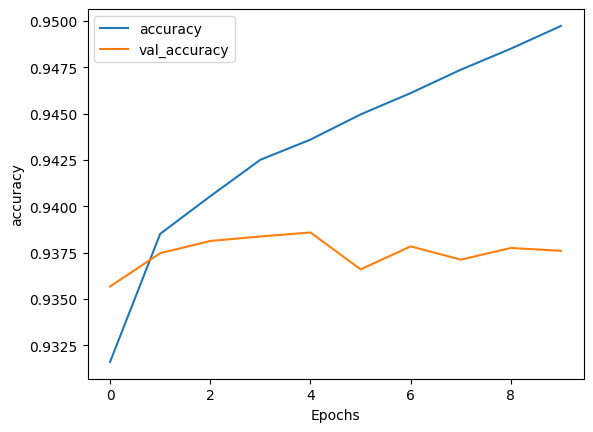

In [89]:
plot_graphs(history5, 'accuracy')

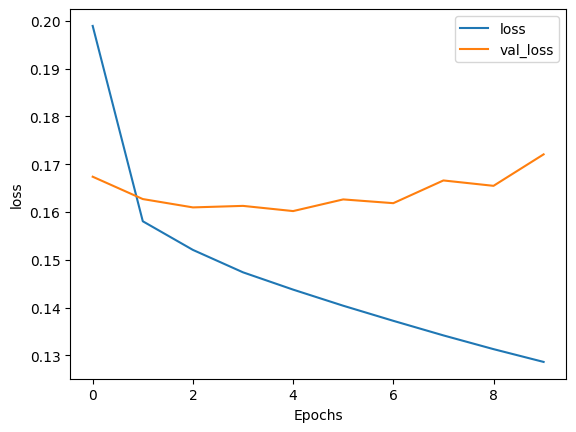

In [90]:
plot_graphs(history5, 'loss')

In [128]:
score5 = model5.evaluate(X_test, y_test, batch_size = 512)
print("\nTest score:", score5[0]) 
print('Test accuracy:', score5[1])

202/202 [==============================] - 49s 241ms/step - loss: 0.1720 - accuracy: 0.9376

Test score: 0.17204774916172028
Test accuracy: 0.9375945329666138


#### Model 6

Input Layer = 55000, Output Layer = 66, Layers = 75, Activation = Relu, <br>
Optimizer = SGD, Batch size = 2042,epoch = 30 	

In [30]:
model6 = Sequential()
model6.add(Embedding(55000, 66, input_length=100))
model6.add(Bidirectional(LSTM(75)))
model6.add(Dense(1, activation='relu'))
model6.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
model6.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 66)           3630000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 150)              85200     
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 1)                 151       
                                                                 
Total params: 3,715,351
Trainable params: 3,715,351
Non-trainable params: 0
_________________________________________________________________


In [32]:
history6 = model6.fit(X_train, y_train, epochs=30, batch_size=2048, validation_data=(X_test, y_test),
                      verbose=2,callbacks=[callback])

Epoch 1/30
202/202 - 926s - loss: 1.1846 - accuracy: 0.9223 - val_loss: 1.2092 - val_accuracy: 0.9207 - 926s/epoch - 5s/step
Epoch 2/30
202/202 - 982s - loss: 1.1846 - accuracy: 0.9223 - val_loss: 1.2092 - val_accuracy: 0.9207 - 982s/epoch - 5s/step
Epoch 3/30
202/202 - 983s - loss: 1.1846 - accuracy: 0.9223 - val_loss: 1.2092 - val_accuracy: 0.9207 - 983s/epoch - 5s/step
Epoch 4/30
202/202 - 917s - loss: 1.1846 - accuracy: 0.9223 - val_loss: 1.2092 - val_accuracy: 0.9207 - 917s/epoch - 5s/step


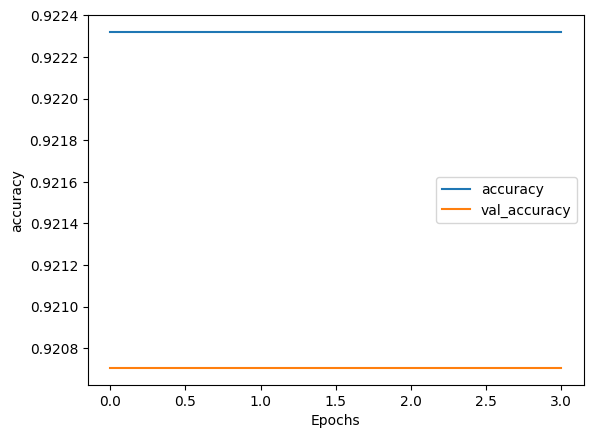

In [91]:
plot_graphs(history6, 'accuracy')

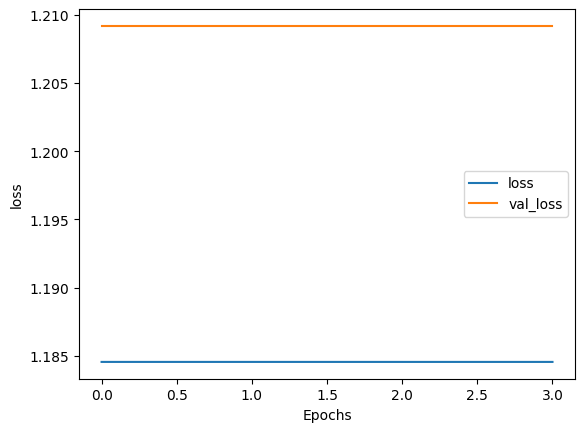

In [92]:
plot_graphs(history6, 'loss')

In [129]:
score6 = model6.evaluate(X_test, y_test, batch_size = 2048)
print("\nTest score:", score6[0]) 
print('Test accuracy:', score6[1])

51/51 [==============================] - 74s 1s/step - loss: 1.2092 - accuracy: 0.9207

Test score: 1.2091704607009888
Test accuracy: 0.9207061529159546


The accuracy of model 6 is slightly less than model 5

### d) GRU

#### Model 7

In [33]:
model7 = Sequential()
model7.add(Embedding(5000, 16, input_length=100))
model7.add(GRU(32))
model7.add(Dense(1, activation='sigmoid'))
model7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model7.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 16)           80000     
                                                                 
 gru (GRU)                   (None, 32)                4800      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 84,833
Trainable params: 84,833
Non-trainable params: 0
_________________________________________________________________


In [40]:
history7 = model7.fit(X_train, y_train, epochs=15, batch_size=1024, validation_data=(X_test, y_test), 
                      verbose=2,callbacks=[callback])

Epoch 1/15
403/403 - 83s - loss: 0.2888 - accuracy: 0.9181 - val_loss: 0.2165 - val_accuracy: 0.9211 - 83s/epoch - 206ms/step
Epoch 2/15
403/403 - 76s - loss: 0.1755 - accuracy: 0.9323 - val_loss: 0.1687 - val_accuracy: 0.9347 - 76s/epoch - 188ms/step
Epoch 3/15
403/403 - 81s - loss: 0.1581 - accuracy: 0.9386 - val_loss: 0.1637 - val_accuracy: 0.9368 - 81s/epoch - 202ms/step
Epoch 4/15
403/403 - 81s - loss: 0.1536 - accuracy: 0.9402 - val_loss: 0.1625 - val_accuracy: 0.9371 - 81s/epoch - 200ms/step
Epoch 5/15
403/403 - 84s - loss: 0.1497 - accuracy: 0.9417 - val_loss: 0.1611 - val_accuracy: 0.9380 - 84s/epoch - 208ms/step
Epoch 6/15
403/403 - 83s - loss: 0.1456 - accuracy: 0.9434 - val_loss: 0.1604 - val_accuracy: 0.9377 - 83s/epoch - 206ms/step
Epoch 7/15
403/403 - 84s - loss: 0.1419 - accuracy: 0.9448 - val_loss: 0.1610 - val_accuracy: 0.9376 - 84s/epoch - 208ms/step
Epoch 8/15
403/403 - 76s - loss: 0.1389 - accuracy: 0.9462 - val_loss: 0.1603 - val_accuracy: 0.9373 - 76s/epoch - 187

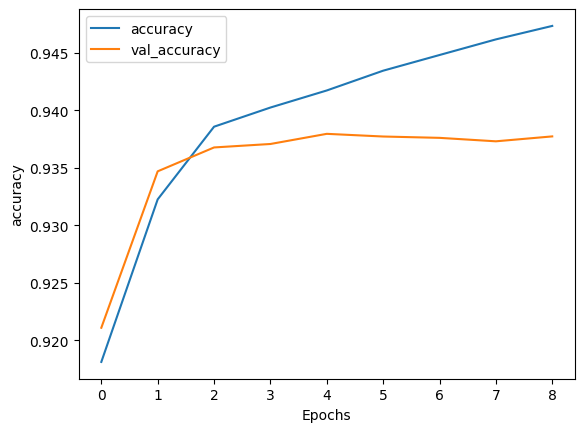

In [93]:
plot_graphs(history7, 'accuracy')

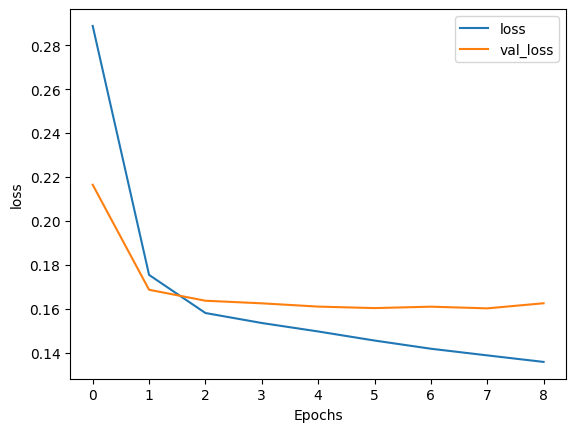

In [94]:
plot_graphs(history7, 'loss')

In [130]:
score7 = model7.evaluate(X_test, y_test, batch_size = 1024)
print("\nTest score:", score7[0]) 
print('Test accuracy:', score7[1])

101/101 [==============================] - 20s 195ms/step - loss: 0.1604 - accuracy: 0.9377

Test score: 0.16037103533744812
Test accuracy: 0.937720537185669


### e) BGRU

#### Model 8

In [97]:
model8 = Sequential()
model8.add(Embedding(5000, 16, input_length=100))
model8.add(Bidirectional(GRU(32)))
model8.add(Dense(1, activation='sigmoid'))
model8.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model8.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 100, 16)           80000     
                                                                 
 bidirectional_13 (Bidirecti  (None, 64)               9600      
 onal)                                                           
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 89,665
Trainable params: 89,665
Non-trainable params: 0
_________________________________________________________________


In [98]:
history8 = model8.fit(X_train, y_train, epochs=10, batch_size=512, validation_data=(X_test, y_test), 
                      verbose=2,callbacks=[callback])

Epoch 1/10
806/806 - 260s - loss: 0.1928 - accuracy: 0.9313 - val_loss: 0.1765 - val_accuracy: 0.9348 - 260s/epoch - 322ms/step
Epoch 2/10
806/806 - 250s - loss: 0.1645 - accuracy: 0.9378 - val_loss: 0.1669 - val_accuracy: 0.9371 - 250s/epoch - 310ms/step
Epoch 3/10
806/806 - 459s - loss: 0.1590 - accuracy: 0.9391 - val_loss: 0.1660 - val_accuracy: 0.9377 - 459s/epoch - 569ms/step
Epoch 4/10
806/806 - 541s - loss: 0.1550 - accuracy: 0.9403 - val_loss: 0.1598 - val_accuracy: 0.9393 - 541s/epoch - 671ms/step
Epoch 5/10
806/806 - 542s - loss: 0.1522 - accuracy: 0.9414 - val_loss: 0.1596 - val_accuracy: 0.9391 - 542s/epoch - 673ms/step
Epoch 6/10
806/806 - 552s - loss: 0.1501 - accuracy: 0.9421 - val_loss: 0.1605 - val_accuracy: 0.9392 - 552s/epoch - 685ms/step
Epoch 7/10
806/806 - 527s - loss: 0.1485 - accuracy: 0.9428 - val_loss: 0.1581 - val_accuracy: 0.9400 - 527s/epoch - 654ms/step
Epoch 8/10
806/806 - 558s - loss: 0.1472 - accuracy: 0.9432 - val_loss: 0.1617 - val_accuracy: 0.9387 - 

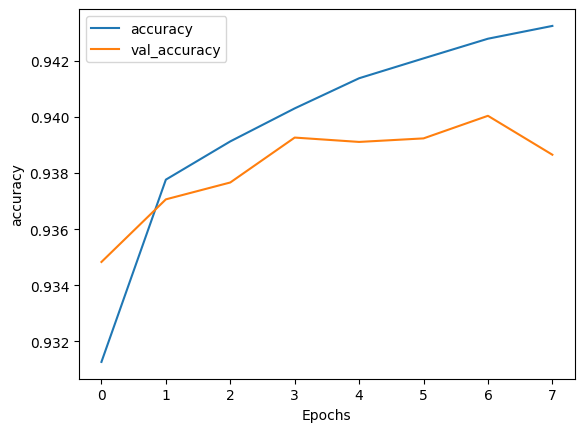

In [99]:
plot_graphs(history8, 'accuracy')

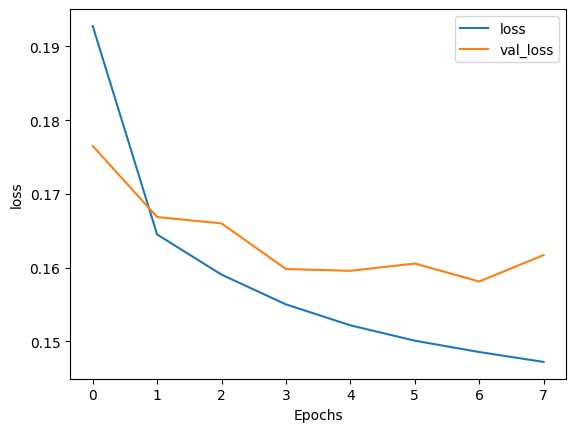

In [100]:
plot_graphs(history8, 'loss')

In [131]:
score8 = model8.evaluate(X_test, y_test, batch_size = 512)
print("\nTest score:", score8[0]) 
print('Test accuracy:', score8[1])

202/202 [==============================] - 34s 168ms/step - loss: 0.1596 - accuracy: 0.9391

Test score: 0.15955856442451477
Test accuracy: 0.9391069412231445


#### Model 9

Input Layer = 7500, Output Layer = 26, Layers = 64, Activation = Sigmoid, <br>
Optimizer = Adam, Batch size = 1024,epoch = 15 

In [70]:
model9 = Sequential()
model9.add(Embedding(7500, 26, input_length=100))
model9.add(Bidirectional(GRU(64)))
model9.add(Dense(1, activation='sigmoid'))
model9.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model9.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 100, 26)           195000    
                                                                 
 bidirectional_12 (Bidirecti  (None, 128)              35328     
 onal)                                                           
                                                                 
 dense_21 (Dense)            (None, 1)                 129       
                                                                 
Total params: 230,457
Trainable params: 230,457
Non-trainable params: 0
_________________________________________________________________


In [71]:
history9 = model9.fit(X_train, y_train, epochs=5, batch_size=1024, validation_data=(X_test, y_test), 
                      verbose=2,callbacks=[callback])

Epoch 1/5
403/403 - 456s - loss: 0.2076 - accuracy: 0.9295 - val_loss: 0.1684 - val_accuracy: 0.9358 - 456s/epoch - 1s/step
Epoch 2/5
403/403 - 486s - loss: 0.1588 - accuracy: 0.9388 - val_loss: 0.1645 - val_accuracy: 0.9371 - 486s/epoch - 1s/step
Epoch 3/5
403/403 - 478s - loss: 0.1541 - accuracy: 0.9399 - val_loss: 0.1647 - val_accuracy: 0.9375 - 478s/epoch - 1s/step
Epoch 4/5
403/403 - 471s - loss: 0.1512 - accuracy: 0.9410 - val_loss: 0.1613 - val_accuracy: 0.9384 - 471s/epoch - 1s/step
Epoch 5/5
403/403 - 479s - loss: 0.1480 - accuracy: 0.9420 - val_loss: 0.1607 - val_accuracy: 0.9385 - 479s/epoch - 1s/step


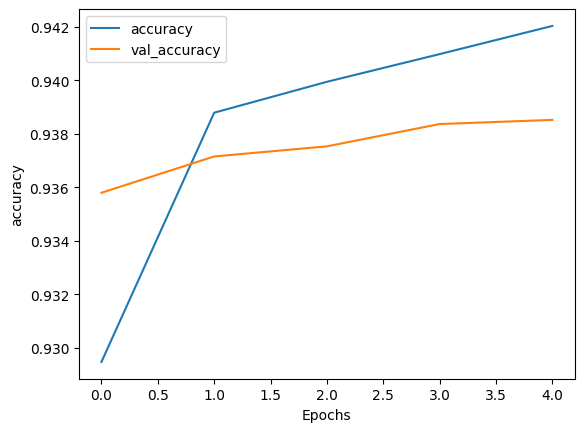

In [95]:
plot_graphs(history9, 'accuracy')

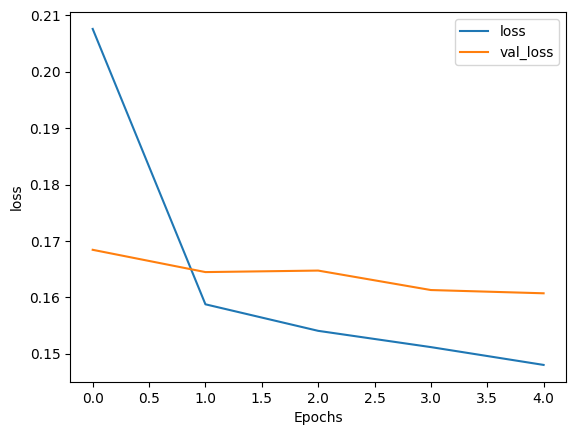

In [96]:
plot_graphs(history9, 'loss')

In [104]:
score9 = model9.evaluate(X_test, y_test, batch_size = 1024,verbose = 0)
print("\nTest score:", score9[0]) 
print('Test accuracy:', score9[1])


Test score: 0.16071482002735138
Test accuracy: 0.9385155439376831


The accuracies of both models are the same.

### Evaluation

In [106]:
# predict using all models
y_pred1 = model1.predict(X_test)
y_pred2 = model2.predict(X_test)
y_pred3 = model3.predict(X_test)
y_pred4 = model4.predict(X_test)
y_pred5 = model5.predict(X_test)
y_pred6 = model6.predict(X_test)
y_pred7 = model7.predict(X_test)
y_pred8 = model8.predict(X_test)
y_pred9 = model9.predict(X_test)

3224/3224 [==============================] - 82s 25ms/step


In [108]:
# convert predictions to binary
y_pred1 = [1 if y>=0.5 else 0 for y in y_pred1]
y_pred2 = [1 if y>=0.5 else 0 for y in y_pred2]
y_pred3 = [1 if y>=0.5 else 0 for y in y_pred3]
y_pred4 = [1 if y>=0.5 else 0 for y in y_pred4]
y_pred5 = [1 if y>=0.5 else 0 for y in y_pred5]
y_pred6 = [1 if y>=0.5 else 0 for y in y_pred6]
y_pred7 = [1 if y>=0.5 else 0 for y in y_pred7]
y_pred8 = [1 if y>=0.5 else 0 for y in y_pred8]
y_pred9 = [1 if y>=0.5 else 0 for y in y_pred9]

In [109]:
report1 = classification_report(y_test,y_pred1,output_dict=True)
report2 = classification_report(y_test,y_pred2,output_dict=True)
report3 = classification_report(y_test,y_pred3,output_dict=True)
report4 = classification_report(y_test,y_pred4,output_dict=True)
report5 = classification_report(y_test,y_pred5,output_dict=True)
report6 = classification_report(y_test,y_pred6,output_dict=True)
report7 = classification_report(y_test,y_pred7,output_dict=True)
report8 = classification_report(y_test,y_pred8,output_dict=True)
report9 = classification_report(y_test,y_pred9,output_dict=True)

C:\Users\Priya\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Priya\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Priya\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [121]:
report1

{'0': {'precision': 0.4827586206896552,
  'recall': 0.010270204181440274,
  'f1-score': 0.0201125344187717,
  'support': 8179},
 '1': {'precision': 0.9213879231650708,
  'recall': 0.9990523223367626,
  'f1-score': 0.958649712290912,
  'support': 94969},
 'accuracy': 0.9206480009307015,
 'macro avg': {'precision': 0.702073271927363,
  'recall': 0.5046612632591014,
  'f1-score': 0.48938112335484185,
  'support': 103148},
 'weighted avg': {'precision': 0.8866073257230805,
  'recall': 0.9206480009307015,
  'f1-score': 0.8842295046493074,
  'support': 103148}}

The standard parameters are Input Layer = 5000, Output Layer = 16, Layers = 32, Activation = Sigmoid,  Optimizer = Adam,

In [136]:
pd.set_option('display.max_colwidth', None)
results = pd.DataFrame({'Model':[i for i in range(1,10)],
                        'Architecture':['RNN','RNN','LSTM','LSTM','BLSTM','BLSTM','GRU','BGRU','BGRU'],
                       'Parameters Used':['Standard, Batch size = 512,epoch = 15 ','''Input Layer = 15000, Output Layer = 30, Layers = 32, Activation = Relu, 
                                          Optimizer = RMSprop, Dropout = 0.5, Batch size = 1024,epoch = 35''',
                                         'Standard,  Batch size = 512 ,epoch = 10',
                                         '''Input Layer = 35000, Output Layer = 40, Layers = 200, Dropout = 0.75,
                                         Activation = Sigmoid, Optimizer = SGD, Batch size = 1024,epoch = 25''',
                                         'Standard, Batch size = 512, epoch = 10',
                                         ''' Input Layer = 55000, Output Layer = 66, Layers = 75, Activation = Relu, 
                                          Optimizer = SGD, Batch size = 2042,epoch = 30''','Standard, Batch size = 1024, epoch = 15',
                                         '''Standard, Batch size = 512, Epoch = 10''',
                                          '''Input Layer = 7500, Output Layer = 26, Layers = 64, Activation = Sigmoid, 
                                          Optimizer = Adam, Batch size = 1024,epoch = 15'''],
                       'Precision':[report1['macro avg']['precision'],report2['macro avg']['precision'],
                                    report3['macro avg']['precision'],report4['macro avg']['precision'],
                                                   report5['macro avg']['precision'],report6['macro avg']['precision'],
                                    report7['macro avg']['precision'],report8['macro avg']['precision'],
                                                   report9['macro avg']['precision']],
                       'Recall':[report1['macro avg']['recall'],report2['macro avg']['recall'],
                                    report3['macro avg']['recall'],report4['macro avg']['recall'],
                                                   report5['macro avg']['precision'],report6['macro avg']['recall'],
                                    report7['macro avg']['recall'],report8['macro avg']['recall'],
                                                   report9['macro avg']['recall']],
                       'f1-Score':[report1['macro avg']['f1-score'],report2['macro avg']['f1-score'],
                                    report3['macro avg']['f1-score'],report4['macro avg']['f1-score'],
                                                   report5['macro avg']['f1-score'],report6['macro avg']['f1-score'],
                                    report7['macro avg']['f1-score'],report8['macro avg']['f1-score'],
                                                   report9['macro avg']['f1-score']],
                       'Test Accuracy':[score1[1],score2[1],score3[1],score4[1],score5[1],score6[1],score7[1],
                                      score8[1],score9[1]]})
results['Test Accuracy'] = results['Test Accuracy']*100
results= results.round(decimals = 3) 
results

,Model,Architecture,Parameters Used,Precision,Recall,f1-Score,Test Accuracy
0,1,RNN,"Standard, Batch size = 512,epoch = 15",0.702,0.505,0.489,92.065
1,2,RNN,"Input Layer = 15000, Output Layer = 30, Layers = 32, Activation = Relu, \n Optimizer = RMSprop, Dropout = 0.5, Batch size = 1024,epoch = 35",0.572,0.502,0.485,91.953
2,3,LSTM,"Standard, Batch size = 512 ,epoch = 10",0.821,0.673,0.720,93.670
3,4,LSTM,"Input Layer = 35000, Output Layer = 40, Layers = 200, Dropout = 0.75,\n Activation = Sigmoid, Optimizer = SGD, Batch size = 1024,epoch = 25",0.460,0.500,0.479,92.071
4,5,BLSTM,"Standard, Batch size = 512, epoch = 10",0.830,0.830,0.721,93.759
5,6,BLSTM,"Input Layer = 55000, Output Layer = 66, Layers = 75, Activation = Relu, \n Optimizer = SGD, Batch size = 2042,epoch = 30",0.460,0.500,0.479,92.071
6,7,GRU,"Standard, Batch size = 1024, epoch = 15",0.808,0.709,0.747,93.772
7,8,BGRU,"Standard, Batch size = 512, Epoch = 10",0.848,0.669,0.722,93.911
8,9,BGRU,"Input Layer = 7500, Output Layer = 26, Layers = 64, Activation = Sigmoid, \n Optimizer = Adam, Batch size = 1024,epoch = 15",0.828,0.685,0.732,93.852
